In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from scipy.stats import itemfreq
import networkx as nx
import pandas as pd

import matplotlib
import seaborn as sns
sns.set_palette('colorblind')
sns.set_style("ticks")
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
matplotlib.rcParams['figure.figsize'] = [10, 8]


matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['xtick.major.size'] = 9
matplotlib.rcParams['ytick.major.size'] = 9
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['ytick.minor.size'] = 4

matplotlib.rcParams['axes.linewidth'] = 2

matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['xtick.minor.width'] = 2
matplotlib.rcParams['ytick.minor.width'] = 2

matplotlib.rcParams['text.usetex'] = True

import random

from toysimulations import Network

import pickle

In [4]:
INS_DATA_COLUMNS = ['time', 'stoplist_len', 'stoplist_volume', 'rest_stoplist_volume',
                    'pickup_idx', 'dropoff_idx', 'insertion_type', 'pickup_enroute',
                    'dropoff_enroute']

PICKLE_FILE_BERLIN = '../data/street_berlin_homogenized.pkl'
PICKLE_FILE_GOE = '../data/street_goe_homogenized.pkl'
PICKLE_FILE_HARZ = '../data/street_harz_homogenized.pkl'

results = dict()

for topology, pickle_file in zip(['berlin', 'goe', 'harz'],
                                 [PICKLE_FILE_BERLIN, PICKLE_FILE_GOE, PICKLE_FILE_HARZ]):
    with open(pickle_file, 'rb') as f:
        results[topology] = pickle.load(f)

In [5]:
import networkx as nx

net_berlin = nx.read_gpickle('../data/homogenized_networks/berlin/G_homog.gpkl')
net_goe = nx.read_gpickle('../data/homogenized_networks/goe/G_homog.gpkl')
net_harz = nx.read_gpickle('../data/homogenized_networks/harz/G_homog.gpkl')

In [6]:
net_harz.number_of_edges(), net_berlin.number_of_edges(), net_goe.number_of_edges()

(546, 641, 511)

In [7]:
net_berlin.order()

419

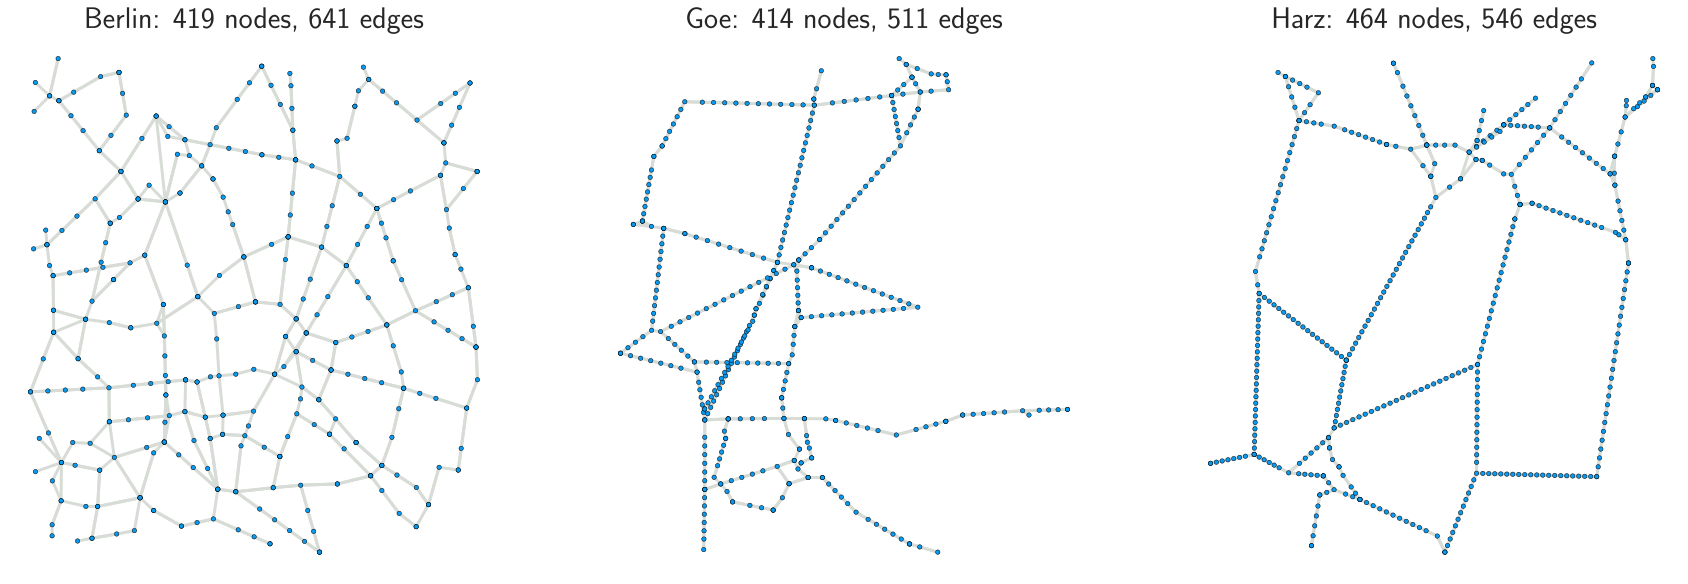

In [8]:
def draw_network(K, ax=None, title="A streetnetwork"):
    if ax is None:
        ax = plt.gca()
    pos = {node:(data['x'], data['y']) for node, data in K.nodes(data=True)}
    
    nx.draw_networkx_nodes(K, pos, node_size=20, node_color='xkcd:azure', edgecolors='k',
                           linewidths=0.5, with_labels=False, ax=ax)
    nx.draw_networkx_edges(K, pos, edge_color='xkcd:light grey', alpha=1, style='solid', width=3.0, ax=ax)

    ax.axis('off')
    ax.set_title(title, fontsize=30)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
draw_network(net_berlin, ax=ax1, title=f"Berlin: {net_berlin.order()} nodes, {net_berlin.size()} edges")
draw_network(net_goe, ax=ax2, title=f"Goe: {net_goe.order()} nodes, {net_goe.size()} edges")
draw_network(net_harz, ax=ax3, title=f"Harz: {net_harz.order()} nodes, {net_harz.size()} edges")

In [9]:
def make_complex_plot(topology, ax, analytics=False):
    result = results[topology]
    x_range = np.array(sorted(result.keys()))
    
    
    n_arr = []
    all_dfs = []
    
    for x in x_range:
        # compute n
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        n = np.mean(ins_df['stoplist_len'])
        
        n_arr.append(n)
        
    
        ins_df = pd.DataFrame(result[x]['insertion_data'], 
                              columns = INS_DATA_COLUMNS)
        ins_df.loc[:, 'x'] = x
        # cut out transients
        ins_df = ins_df.iloc[int(-0.8*len(ins_df)):, :]
        all_dfs.append(ins_df)
    if analytics == False:
        l, = ax.plot(x_range, n_arr, 'o', markersize=5, label=topology, zorder=2)
    else:
        l, = ax.plot(x_range, n_arr, label='data', zorder=2)

    ax.set_xlim(0,40)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$n$")
    return l


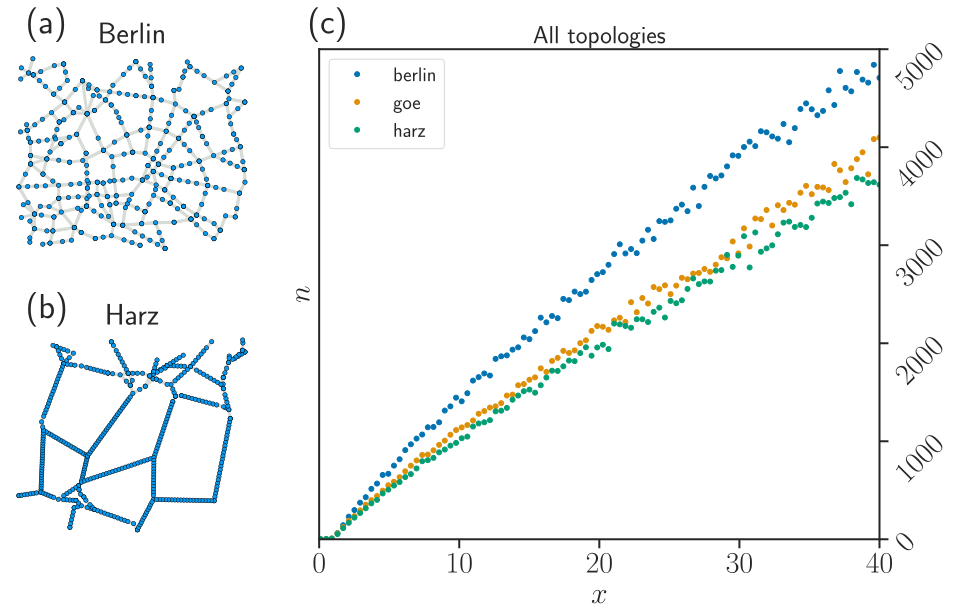

In [10]:
fig = plt.figure(figsize=(14,12))

ax1 = plt.subplot2grid((3, 3), (0, 0), fig=fig)
ax2 = plt.subplot2grid((3, 3), (1, 0), fig=fig)
ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=2, colspan=2, fig=fig)

topologies_ordered = ('berlin', 'goe', 'harz')

draw_network(net_berlin, ax=ax1, title='Berlin')
draw_network(net_harz, ax=ax2, title='Harz')


topo_line_map = dict()
for topology in topologies_ordered:
    line = make_complex_plot(topology, ax3)
    topo_line_map[topology] = line
    
ax3.set_title('All topologies', fontsize=25)

# legend
legend_order = ['berlin', 'goe', 'harz']
ax3.legend([topo_line_map[t] for t in legend_order], legend_order, fontsize=20)


ax3.yaxis.tick_right()
for ax in (ax1, ax2, ax3):
    ax.yaxis.set_tick_params(rotation=45)

# letter as subfigure captions
fig.text(0.05, 0.95, '(a)', fontsize=35, transform=fig.transFigure)
fig.text(0.33, 0.95, '(c)', fontsize=35, transform=fig.transFigure)
fig.text(0.05, 0.62, '(b)', fontsize=35, transform=fig.transFigure)
    

ax3.set_ylim(0, 5000)
fig.tight_layout(h_pad=0.1)
fig.savefig('n_vs_x_streetnetworks_homog.pdf', bbox_inches='tight')